<a href="https://colab.research.google.com/github/Abuton/HamoyeMLCodeClub/blob/master/InsuranceClaimNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoInland Vehicle Insurance Claim Challenge StarterNotebook - Python

This is a simple starter notebook to get started with the AutoInland Vehicle Insurance Claim Challenge on Zindi.

This notebook covers:
- Loading the data
- Simple EDA and an example of feature enginnering
- Data preprocessing and data wrangling
- Creating a simple model
- Making a submission
- Some tips for improving your score

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

### Read files

In [3]:
# Load files into a pandas dataframe
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission (1).csv')

### Some basic EDA

In [4]:
# Preview the first five rows of the train set
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [5]:
# Preview the first five rows of the test set
test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


In [6]:
# Preview the first five rows of the sample submission file
ss.head()

,ID,target
0,ID_01QM0NU,0
1,ID_024NJLZ,0
2,ID_02NOVWQ,0
3,ID_02VSP68,0
4,ID_02YB37K,0


In [7]:
# Check the shape of the train and test sets
print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

The shape of the train set is: (12079, 14)
The shape of the test set is: (1202, 13)


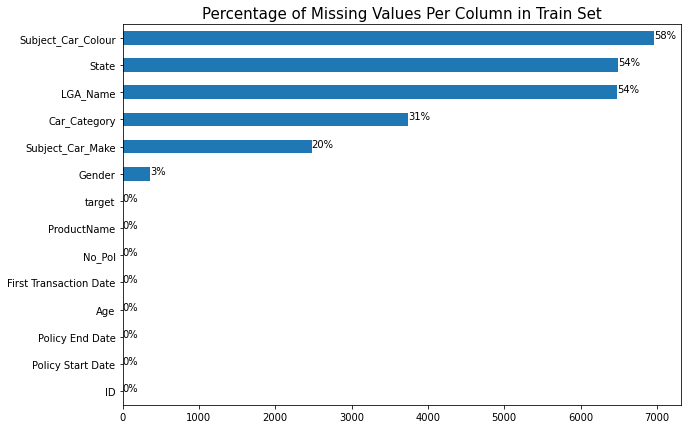

In [8]:
# Check if there any missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

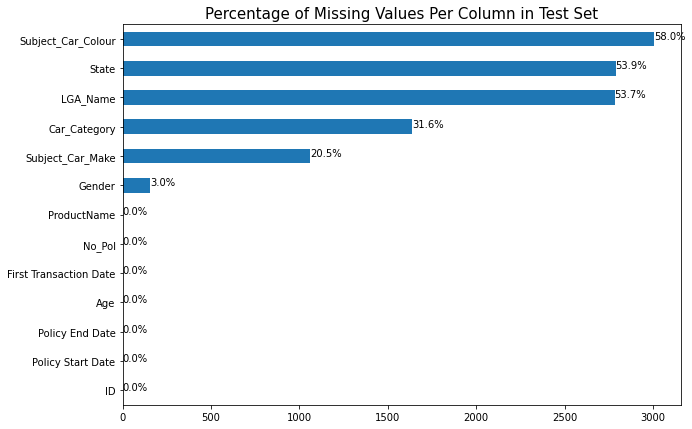

In [ ]:
# Check if there missing values in test set
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

## Combine train and test set for easy preprocessing 

In [9]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (13281, 14)


In [ ]:
# Preview the last five rows of the combined dataframe
all_data.tail()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
17251,ZYXX5AF,2010-07-18,2011-07-17,Male,48,2010-07-18,1,Saloon,NaN,Honda,NaN,NaN,CarSafe,NaN
17252,ZYYOZ5L,2010-12-04,2011-12-03,NaN,50,2010-12-04,1,NaN,NaN,NaN,Victoria Island,Lagos,Car Classic,NaN
17253,ZZ1GTKD,2010-09-24,2011-09-23,Male,1,2010-09-24,1,NaN,NaN,NaN,NaN,NaN,CarSafe,NaN
17254,ZZDXQSI,2010-07-17,2011-07-16,Female,52,2010-07-17,1,Saloon,Grey,TOYOTA,NaN,NaN,Car Classic,NaN
17255,ZZYTLV1,2010-07-17,2011-07-16,Male,68,2010-07-17,1,Saloon,NaN,Peugeot,NaN,NaN,CarSafe,NaN


In [ ]:
# Check the column names and datatypes
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17256 entries, 0 to 17255
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      17256 non-null  object 
 1   Policy Start Date       17256 non-null  object 
 2   Policy End Date         17256 non-null  object 
 3   Gender                  16741 non-null  object 
 4   Age                     17256 non-null  int64  
 5   First Transaction Date  17256 non-null  object 
 6   No_Pol                  17256 non-null  int64  
 7   Car_Category            11880 non-null  object 
 8   Subject_Car_Colour      7289 non-null   object 
 9   Subject_Car_Make        13719 non-null  object 
 10  LGA_Name                7998 non-null   object 
 11  State                   7980 non-null   object 
 12  ProductName             17256 non-null  object 
 13  target                  12079 non-null  float64
dtypes: float64(1), int64(2), object(11)
me

In [10]:
# Change each column to its appriopriate datatype
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target']]

for col in all_data.columns:
  if col in date_cols:
    all_data[col] = pd.to_datetime(all_data[col])
  elif col in cat_cols:
    all_data[col] = all_data[col].astype('category')

# Confirm whether the changes have been applied successfully
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      13281 non-null  object        
 1   Policy Start Date       13281 non-null  datetime64[ns]
 2   Policy End Date         13281 non-null  datetime64[ns]
 3   Gender                  12881 non-null  category      
 4   Age                     13281 non-null  int64         
 5   First Transaction Date  13281 non-null  datetime64[ns]
 6   No_Pol                  13281 non-null  int64         
 7   Car_Category            9171 non-null   category      
 8   Subject_Car_Colour      5622 non-null   category      
 9   Subject_Car_Make        10557 non-null  category      
 10  LGA_Name                6149 non-null   category      
 11  State                   6137 non-null   category      
 12  ProductName             13281 non-null  catego

### Distribution of the target variable

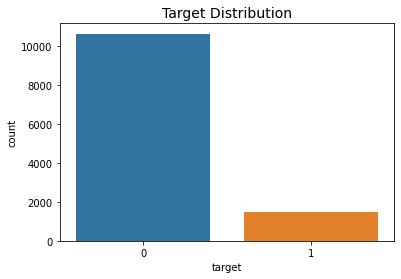

In [11]:
sns.countplot(train.target)
plt.title('Target Distribution', fontdict={'size':14});

### Distribution of the Gender column

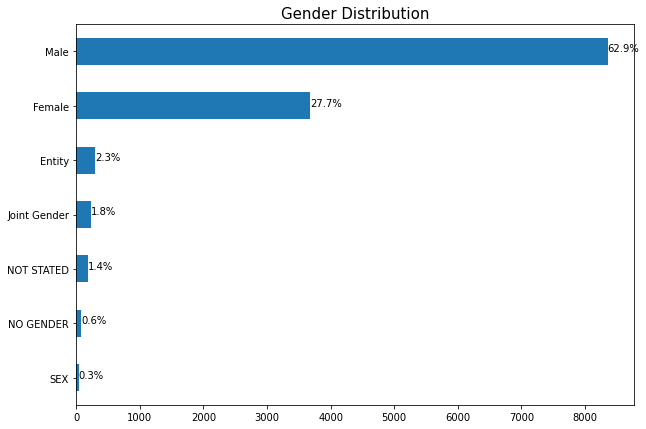

In [14]:
def plot_dist(data, cat_col):
  # Gender distribution 
  ax = data[cat_col].value_counts().sort_values().plot(kind = 'barh', figsize=(10,7))
  plt.title('Gender Distribution', fontdict={'size': 15})
  for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/all_data.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))
  plt.show()

plot_dist(all_data, "Gender")

In [15]:
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
all_data.Gender = all_data.Gender.replace(mapper)

# Confirm mappings
all_data.Gender.value_counts()

Male      8356
Female    3679
Other      846
Name: Gender, dtype: int64

### Number of unique values per categorical column

In [ ]:
# Check unique values for each categorical column
for col in cat_cols:
  print(col)
  print(all_data[col].unique(), '\n')

Gender
['Male' 'Female' 'Other' nan] 

Car_Category
['Saloon', 'JEEP', NaN, 'Motorcycle', 'Truck', ..., 'Wagon', 'Shape Of Vehicle Chasis', 'Sedan', 'Station 4 Wheel', 'Tipper Truck']
Length: 17
Categories (16, object): ['Saloon', 'JEEP', 'Motorcycle', 'Truck', ..., 'Shape Of Vehicle Chasis',
                          'Sedan', 'Station 4 Wheel', 'Tipper Truck'] 

Subject_Car_Colour
['Black', 'Grey', 'Red', NaN, 'As Attached', ..., 'Yellow & White', 'Beige Mitalic', 'Light Gray', 'Blue Sky', 'Red Maroon']
Length: 47
Categories (46, object): ['Black', 'Grey', 'Red', 'As Attached', ..., 'Beige Mitalic',
                          'Light Gray', 'Blue Sky', 'Red Maroon'] 

Subject_Car_Make
['TOYOTA', NaN, 'REXTON', 'Lexus', 'Hyundai', ..., 'BRILLIANCE', 'Buik', 'COMMANDER', 'Bajaj', 'Datsun']
Length: 76
Categories (75, object): ['TOYOTA', 'REXTON', 'Lexus', 'Hyundai', ..., 'Buik', 'COMMANDER', 'Bajaj',
                          'Datsun'] 

LGA_Name
[NaN, 'Lagos', 'Ikeja', 'Badagry', 'Eti-Osa

### Filling in missing values
#### Missing values can be filled using different strategies
Tips:
 - Mean
 - Max
 - Min
 - [sklearn SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)
 - Others... do more reasearch

In [16]:
# Fill in missing values
# For cat cols and date cols fill in with mode and for num cols fill in with 9999
for col in all_data.columns:
  if col in date_cols+cat_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
  elif col in num_cols:
    all_data[col] = all_data[col].fillna(all_data[col].fillna(-999))

# Confirm that there aren't any missing values
all_data[all_data.columns.difference(['target'])].isna().sum()

Age                       0
Car_Category              0
First Transaction Date    0
Gender                    0
ID                        0
LGA_Name                  0
No_Pol                    0
Policy End Date           0
Policy Start Date         0
ProductName               0
State                     0
Subject_Car_Colour        0
Subject_Car_Make          0
dtype: int64

### Feature Engineering
#### Alot of features can be extracted from dates
Tips:
 - Quarter, Start of Year, month?
 - Is it a weekend, weekday?
 - Is it a holiday
 - Duration between different periods, e.g start and end of a policy
 - What features can be derived from the age column
 - Be creative 😉

In [18]:
# Extract date features from the date columns
for col in date_cols:
  for date_feature in ['year', 'month', 'day', 'quarter', 'is_month_end']:
    all_data[col+date_feature] = getattr(all_data[col].dt, date_feature)

all_data.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Policy Start Dateyear,Policy Start Datemonth,Policy Start Dateday,Policy Start Datequarter,Policy Start Dateis_month_end,Policy End Dateyear,Policy End Datemonth,Policy End Dateday,Policy End Datequarter,Policy End Dateis_month_end,First Transaction Dateyear,First Transaction Datemonth,First Transaction Dateday,First Transaction Datequarter,First Transaction Dateis_month_end
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,Victoria Island,Lagos,Car Classic,0.0,2010,5,14,2,False,2011,5,13,2,False,2010,5,14,2,False
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,Victoria Island,Lagos,Car Classic,1.0,2010,11,29,4,False,2011,11,28,4,False,2010,11,29,4,False
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,Victoria Island,Lagos,Car Classic,0.0,2010,3,21,1,False,2011,3,20,1,False,2010,3,21,1,False
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,Saloon,Black,TOYOTA,Victoria Island,Lagos,CarSafe,0.0,2010,8,21,3,False,2011,8,20,3,False,2010,8,21,3,False
4,ID_00BRP63,2010-08-29,2010-12-31,Other,20,2010-08-29,3,Saloon,Black,TOYOTA,Lagos,Lagos,Muuve,1.0,2010,8,29,3,False,2010,12,31,4,True,2010,8,29,3,False


In [20]:
# bucketize the age column
all_data['bin_Age'] = pd.cut(all_data['Age'], bins=[0,20,40,60,200], labels=['young', 'youth', 'matured', 'old'])

#### Try different strategies of dealing with categorical variables
Tips:
 - One hot encoding
 - Label encoding
 - Target encoding
 - Reduce the number of unique values...

In [ ]:
# # Encode categorical features
# all_data = pd.get_dummies(data = all_data, columns = cat_cols+['bin_Age'])
# all_data.head()

,ID,Policy Start Date,Policy End Date,Age,First Transaction Date,No_Pol,target,Policy Start Dateyear,Policy Start Datemonth,Policy Start Dateday,Policy End Dateyear,Policy End Datemonth,Policy End Dateday,First Transaction Dateyear,First Transaction Datemonth,First Transaction Dateday,Gender_Female,Gender_Male,Gender_Other,Car_Category_Bus,Car_Category_CAMRY CAR HIRE,Car_Category_JEEP,Car_Category_Mini Bus,Car_Category_Mini Van,Car_Category_Motorcycle,Car_Category_Pick Up,Car_Category_Pick Up > 3 Tons,Car_Category_Saloon,Car_Category_Sedan,Car_Category_Shape Of Vehicle Chasis,Car_Category_Station 4 Wheel,Car_Category_Tipper Truck,Car_Category_Truck,Car_Category_Van,Car_Category_Wagon,Subject_Car_Colour_As Attached,Subject_Car_Colour_Ash,Subject_Car_Colour_B.Silver,Subject_Car_Colour_Beige Mitalic,Subject_Car_Colour_Black,...,State_Nsit-Ubium,State_Obafemi-Owode,State_Obia-Akpor,State_Ogba-Ndoni,State_Ogbmosho-South,State_Ogun,State_Ogun-Waterside,State_Ondo,State_Ondo-West,State_Onitsha-North,State_Onitsha-South,State_Orile-Iganmu,State_Oshimili-North,State_Oshodi-Isolo,State_Osun,State_Ovia-SouthWest,State_Owerri-Municipal,State_Owerri-North,State_Owerri-West,State_Oyo,State_Oyo-East,State_Oyo-West,State_Port-Harcourt,State_QuaAn-Pan,State_Rivers,State_Udi-Agwu,State_Ughelli-North,State_Umuahia-South,State_Warri-Central,State_Warri-North,State_Warri-South,ProductName_CVTP,ProductName_Car Classic,ProductName_Car Plus,ProductName_Car Vintage,ProductName_CarFlex,ProductName_CarSafe,ProductName_Customized Motor,ProductName_Motor Cycle,ProductName_Muuve
0,0040R73,2010-05-14,2011-05-13,30,2010-05-14,1,0.0,2010,5,14,2011,5,13,2010,5,14,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0046BNK,2010-11-29,2011-11-28,79,2010-11-29,1,1.0,2010,11,29,2011,11,28,2010,11,29,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,005QMC3,2010-03-21,2011-03-20,43,2010-03-21,1,0.0,2010,3,21,2011,3,20,2010,3,21,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0079OHW,2010-08-21,2011-08-20,2,2010-08-21,1,0.0,2010,8,21,2011,8,20,2010,8,21,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,00BRP63,2010-08-29,2010-12-31,20,2010-08-29,3,1.0,2010,8,29,2010,12,31,2010,8,29,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
pip install category_encoders

In [27]:
# Encode categorical features using target encoding
import category_encoders as ce
target_enc = ce.TargetEncoder(cols=cat_cols+['bin_Age'])

target_enc.fit(all_data[cat_cols+['bin_Age']], all_data['target'])

# Transform the features
all_data_enc = all_data.join(target_enc.transform(all_data[cat_cols+['bin_Age']]).add_suffix('_target'))

In [29]:
all_data_enc.head(2)

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Policy Start Dateyear,Policy Start Datemonth,Policy Start Dateday,Policy Start Datequarter,Policy Start Dateis_month_end,Policy End Dateyear,Policy End Datemonth,Policy End Dateday,Policy End Datequarter,Policy End Dateis_month_end,First Transaction Dateyear,First Transaction Datemonth,First Transaction Dateday,First Transaction Datequarter,First Transaction Dateis_month_end,bin_Age,Gender_target,Car_Category_target,Subject_Car_Colour_target,Subject_Car_Make_target,LGA_Name_target,State_target,ProductName_target,bin_Age_target
0,ID_0040R73,2010-05-14,2011-05-13,1,30,2010-05-14,1,8,4,68,258,74,1,0.0,2010,5,14,2,False,2011,5,13,2,False,2010,5,14,2,False,youth,0.120612,0.116967,0.081430,0.120789,0.096229,0.109882,0.165613,0.148011
1,ID_0046BNK,2010-11-29,2011-11-28,0,79,2010-11-29,1,2,26,68,258,74,1,1.0,2010,11,29,4,False,2011,11,28,4,False,2010,11,29,4,False,old,0.107604,0.122712,0.245136,0.120789,0.096229,0.109882,0.165613,0.101115


In [30]:
cols_2_drop = ['ID', 'Policy Start Date', 'Policy End Date', 'First Transaction Date', "LGA_Name", 'Car_Category', 
               'Subject_Car_Color', 'Subject_Car_Make', "State",'ProductName']

In [ ]:
import itertools

interactions = pd.DataFrame(index=all_data_enc.index)

# Iterate through each pair of features, combine them into interaction features
for col1, col2 in itertools.combinations(cat_cols+['bin_Age'], 2):
        new_col_name = '_'.join([col1, col2])

        # Convert to strings and combine
        new_values = all_data_enc[col1].map(str) + "_" + all_data_enc[col2].map(str)

        encoder = LabelEncoder()
        interactions[new_col_name] = encoder.fit_transform(new_values)

interactions.shape

In [34]:
# Separate train and test data from the combined dataframe
train_df = all_data_enc[:ntrain]
test_df = all_data_enc[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((12079, 38), (1202, 38))

### Training and making predictions
Tips:
- Is lgbm the best model for this challenge?
- Parameter tuning
 - Grid search, random search, perhaps bayesian search works better...



In [41]:
from sklearn.ensemble import GradientBoostingClassifier
grb = GradientBoostingClassifier(n_estimators=400)
# Select main columns to be used in training
main_cols = all_data.columns.difference(cols_2_drop+['target', 'bin_Age'])
X = train_df[main_cols]
y = train_df.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Train model
model = LGBMClassifier(n_estimators=500, learning_rate=0.01)
grb.fit(X_train, y_train)

# Make predictions
y_pred = grb.predict(X_test)

# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')

F1 score on the X_test is: 0.14245014245014245


In [ ]:
pip install catboost

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
from catboost import CatBoostClassifier
kfold, scores, y_pred_totcb = StratifiedKFold(n_splits=5, shuffle=True, random_state=221), list(), []
for train, test in kfold.split(X, y):
    x_train, x_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]
    
    model = CatBoostClassifier(random_state=27,  n_estimators=3000,
                               max_depth=7, verbose=500, learning_rate=0.102, eval_metric='F1')
    model.fit(x_train, y_train, eval_set=(x_test, y_test))
    preds = model.predict(x_test)
    score = f1_score(y_test, preds)
    scores.append(score)
    print(score)
    test_pred = model.predict(test_df[main_cols])
    y_pred_totcb.append(test_pred)
print("Average: ", sum(scores)/len(scores))

#### [More on F1 Score](https://en.wikipedia.org/wiki/F-score)

### Making predictions of the test set and creating a submission file

In [47]:
ss['target'] = np.mean(y_pred_totcb, 0)

In [48]:
ss.to_csv('sht.csv', index=False)

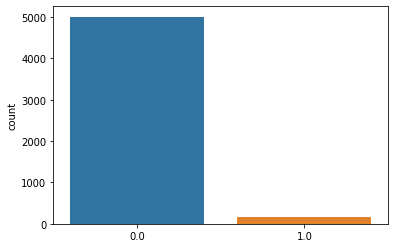

In [ ]:
# Make prediction on the test set
test_df = test_df[main_cols]
predictions = model.predict(test_df)

# Create a submission file
sub_file = ss.copy()
sub_file.predictions = predictions

# Check the distribution of your predictions
sns.countplot(sub_file.predictions);

In [ ]:
# Create a csv file and upload to zindi 
sub_file.to_csv('Baseline.csv', index = False)

###More Tips
- Thorough EDA and domain knowledge sourcing
- Re-group Categorical features 
- More Feature Engineering 
- Dataset balancing - oversampling, undersampling, SMOTE...
- Ensembling of models 
- Cross-validation: Group folds, Stratified...

# ******************* GOOD LUCK!!! ***************************

In [ ]:
pip install h2o

In [51]:
import h2o
from h2o.automl import H2OAutoML

In [ ]:
h2o.init()

In [69]:
h2o_element = all_data.columns.difference(cols_2_drop+['bin_Age'])

In [70]:
h2o_train = h2o.H2OFrame(train_df[h2o_element])
h2o_train['target'] = h2o_train['target'].asfactor()

h2o_aml = H2OAutoML(max_runtime_secs=60, nfolds=0)
h2o_aml.train(y='target', training_frame=h2o_train)

Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


In [71]:
h2o_aml.leaderboard.head(rows=h2o_aml.leaderboard.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XGBoost_grid__1_AutoML_20210501_134542_model_7,0.743073,0.363789,0.353696,0.326941,0.330102,0.108967
XGBoost_grid__1_AutoML_20210501_134542_model_2,0.736927,0.370736,0.340326,0.338289,0.332796,0.110753
GBM_5_AutoML_20210501_134542,0.734428,0.36556,0.346691,0.326975,0.331799,0.110091
XGBoost_3_AutoML_20210501_134542,0.730232,0.365453,0.361893,0.340762,0.330103,0.108968
XGBoost_grid__1_AutoML_20210501_134542_model_1,0.729297,0.365479,0.348631,0.352458,0.330397,0.109162
XGBoost_grid__1_AutoML_20210501_134542_model_6,0.728254,0.374621,0.329862,0.339054,0.333638,0.111314
GBM_1_AutoML_20210501_134542,0.725047,0.366515,0.353236,0.328964,0.330787,0.10942
GBM_grid__1_AutoML_20210501_134542_model_1,0.722965,0.366485,0.357051,0.331939,0.330674,0.109345
GBM_3_AutoML_20210501_134542,0.722721,0.369159,0.342679,0.337651,0.332554,0.110592
XGBoost_grid__1_AutoML_20210501_134542_model_4,0.722426,0.375939,0.329014,0.316376,0.333201,0.111023


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XGBoost_grid__1_AutoML_20210501_134542_model_7,0.743073,0.363789,0.353696,0.326941,0.330102,0.108967
XGBoost_grid__1_AutoML_20210501_134542_model_2,0.736927,0.370736,0.340326,0.338289,0.332796,0.110753
GBM_5_AutoML_20210501_134542,0.734428,0.36556,0.346691,0.326975,0.331799,0.110091
XGBoost_3_AutoML_20210501_134542,0.730232,0.365453,0.361893,0.340762,0.330103,0.108968
XGBoost_grid__1_AutoML_20210501_134542_model_1,0.729297,0.365479,0.348631,0.352458,0.330397,0.109162
XGBoost_grid__1_AutoML_20210501_134542_model_6,0.728254,0.374621,0.329862,0.339054,0.333638,0.111314
GBM_1_AutoML_20210501_134542,0.725047,0.366515,0.353236,0.328964,0.330787,0.10942
GBM_grid__1_AutoML_20210501_134542_model_1,0.722965,0.366485,0.357051,0.331939,0.330674,0.109345
GBM_3_AutoML_20210501_134542,0.722721,0.369159,0.342679,0.337651,0.332554,0.110592
XGBoost_grid__1_AutoML_20210501_134542_model_4,0.722426,0.375939,0.329014,0.316376,0.333201,0.111023


In [73]:
h2o_aml.leader

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid__1_AutoML_20210501_134542_model_7


Model Summary: 


,,number_of_trees
0,,40.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.07971444449484004
RMSE: 0.2823374656237462
LogLoss: 0.2715495136873906
Mean Per-Class Error: 0.2311537901427777
AUC: 0.8520239323462027
AUCPR: 0.5106884413880269
Gini: 0.7040478646924053

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22443867623806: 


,,0,1,Error,Rate
0,0,7834.0,682.0,0.0801,(682.0/8516.0)
1,1,544.0,601.0,0.4751,(544.0/1145.0)
2,Total,8378.0,1283.0,0.1269,(1226.0/9661.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.224439,0.495058,168.0
1,max f2,0.114393,0.592513,259.0
2,max f0point5,0.340108,0.535359,106.0
3,max accuracy,0.376324,0.899079,90.0
4,max precision,0.885895,1.000000,0.0
5,max recall,0.020422,1.000000,382.0
6,max specificity,0.885895,1.000000,0.0
7,max absolute_mcc,0.262155,0.430394,144.0
8,max min_per_class_accuracy,0.129851,0.765939,244.0
9,max mean_per_class_accuracy,0.114393,0.768846,259.0



Gains/Lift Table: Avg response rate: 11.85 %, avg score: 11.88 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010144,0.678346,7.232190,7.232190,0.857143,0.753413,0.857143,0.753413,0.073362,0.073362,623.218964,623.218964,0.071718
1,2,0.020081,0.514250,6.503948,6.871823,0.770833,0.576672,0.814433,0.665954,0.064629,0.137991,550.394833,587.182281,0.133764
2,3,0.030018,0.438934,5.273472,6.342713,0.625000,0.472537,0.751724,0.601926,0.052402,0.190393,427.347162,534.271345,0.181938
3,4,0.040058,0.401326,5.045136,6.017481,0.597938,0.421199,0.713178,0.556628,0.050655,0.241048,404.513573,501.748079,0.228014
4,5,0.050098,0.367030,4.349255,5.683146,0.515464,0.382323,0.673554,0.521694,0.043668,0.284716,334.925494,468.314627,0.266163
5,6,0.100093,0.259190,3.319121,4.502356,0.393375,0.309522,0.533609,0.415718,0.165939,0.450655,231.912085,350.235591,0.397696
6,7,0.150088,0.207806,2.096287,3.700886,0.248447,0.231717,0.438621,0.354426,0.104803,0.555459,109.628685,270.088601,0.459874
7,8,0.200083,0.172940,1.659560,3.190819,0.196687,0.190060,0.378169,0.313356,0.082969,0.638428,65.956043,219.081862,0.497282
8,9,0.300072,0.128014,1.301445,2.561245,0.154244,0.148598,0.303553,0.258456,0.130131,0.768559,30.144475,156.124458,0.531476
9,10,0.400062,0.098962,0.864718,2.137223,0.102484,0.112428,0.253299,0.221958,0.086463,0.855022,-13.528167,113.722275,0.516130




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.09060952518270551
RMSE: 0.3010141610999481
LogLoss: 0.31008489722807087
Mean Per-Class Error: 0.2872482682998583
AUC: 0.7649835521917039
AUCPR: 0.3061949230390133
Gini: 0.5299671043834078

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18329977989196777: 


,,0,1,Error,Rate
0,0,932.0,144.0,0.1338,(144.0/1076.0)
1,1,68.0,71.0,0.4892,(68.0/139.0)
2,Total,1000.0,215.0,0.1745,(212.0/1215.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.183300,0.401130,144.0
1,max f2,0.106655,0.514781,227.0
2,max f0point5,0.312683,0.391389,69.0
3,max accuracy,0.700192,0.887243,6.0
4,max precision,0.700192,0.600000,6.0
5,max recall,0.008734,1.000000,394.0
6,max specificity,0.882818,0.999071,0.0
7,max absolute_mcc,0.165231,0.315972,160.0
8,max min_per_class_accuracy,0.108595,0.709108,224.0
9,max mean_per_class_accuracy,0.106655,0.712752,227.0



Gains/Lift Table: Avg response rate: 11.44 %, avg score: 11.67 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010700,0.677161,4.706696,4.706696,0.538462,0.736937,0.538462,0.736937,0.050360,0.050360,370.669618,370.669618,0.044784
1,2,0.020576,0.514606,2.913669,3.846043,0.333333,0.547121,0.440000,0.645825,0.028777,0.079137,191.366906,284.604317,0.066126
2,3,0.031276,0.432987,2.689541,3.450398,0.307692,0.458884,0.394737,0.581872,0.028777,0.107914,168.954068,245.039758,0.086538
3,4,0.040329,0.387442,3.973185,3.567758,0.454545,0.411584,0.408163,0.543644,0.035971,0.143885,297.318509,256.775804,0.116933
4,5,0.050206,0.369686,4.370504,3.725675,0.500000,0.378077,0.426230,0.511073,0.043165,0.187050,337.050360,272.567520,0.154522
5,6,0.100412,0.268335,2.865904,3.295790,0.327869,0.313996,0.377049,0.412534,0.143885,0.330935,186.590400,229.578960,0.260303
6,7,0.150617,0.204403,2.006133,2.865904,0.229508,0.233004,0.327869,0.352691,0.100719,0.431655,100.613280,186.590400,0.317342
7,8,0.200000,0.169180,2.185252,2.697842,0.250000,0.185551,0.308642,0.311422,0.107914,0.539568,118.525180,169.784173,0.383435
8,9,0.300412,0.121727,1.146362,2.179265,0.131148,0.142500,0.249315,0.254960,0.115108,0.654676,14.636160,117.926481,0.400029
9,10,0.400000,0.092760,1.083596,1.906475,0.123967,0.106082,0.218107,0.217894,0.107914,0.762590,8.359593,90.647482,0.409430




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-05-01 13:46:22,12.798 sec,0.0,0.500000,0.693147,0.500000,0.118518,1.000000,0.881482,0.500000,0.693147,0.500000,0.114403,1.000000,0.885597
1,,2021-05-01 13:46:22,12.918 sec,5.0,0.314336,0.349273,0.746340,0.343483,6.285117,0.184867,0.315385,0.350554,0.742261,0.282455,4.034311,0.196708
2,,2021-05-01 13:46:22,13.044 sec,10.0,0.300691,0.312897,0.774369,0.382542,6.436897,0.157023,0.304505,0.319739,0.748750,0.286696,4.706696,0.226337
3,,2021-05-01 13:46:23,13.178 sec,15.0,0.295771,0.300364,0.796900,0.416516,6.647770,0.138081,0.302239,0.313092,0.756679,0.300371,4.034311,0.185185
4,,2021-05-01 13:46:23,13.305 sec,20.0,0.292213,0.292403,0.812425,0.440995,6.871823,0.130214,0.301482,0.311648,0.759060,0.309734,4.994861,0.162963
5,,2021-05-01 13:46:23,13.483 sec,25.0,0.289729,0.286802,0.824335,0.458958,6.871823,0.125867,0.301350,0.310900,0.760437,0.307215,4.706696,0.176132
6,,2021-05-01 13:46:23,13.611 sec,30.0,0.287500,0.282306,0.831917,0.474226,6.958808,0.125556,0.300838,0.309211,0.763409,0.309901,4.706696,0.172840
7,,2021-05-01 13:46:23,13.749 sec,35.0,0.284585,0.276235,0.844386,0.495252,7.146092,0.121520,0.300587,0.309277,0.763275,0.307355,4.706696,0.172840
8,,2021-05-01 13:46:23,13.908 sec,40.0,0.282337,0.271550,0.852024,0.510688,7.232190,0.126902,0.301014,0.310085,0.764984,0.306195,4.706696,0.174486



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Age,841.148315,1.000000,0.255680
1,Subject_Car_Colour,585.070129,0.695561,0.177841
2,First Transaction Dateday,335.341949,0.398672,0.101932
3,Policy End Dateday,304.586517,0.362108,0.092584
4,Policy End Datemonth,236.016891,0.280589,0.071741
5,First Transaction Datemonth,222.134171,0.264084,0.067521
6,No_Pol,220.049438,0.261606,0.066887
7,Policy End Dateyear,173.124741,0.205820,0.052624
8,Gender,135.516724,0.161109,0.041192
9,Policy Start Dateday,78.113739,0.092866,0.023744


In [74]:
model_id = h2o_aml.leaderboard.as_data_frame().model_id[4]
print(f'Model: {model_id}')

h2o.get_model(model_id)

Model: XGBoost_grid__1_AutoML_20210501_134542_model_1
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid__1_AutoML_20210501_134542_model_1


Model Summary: 


,,number_of_trees
0,,40.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.08778010350717595
RMSE: 0.2962770721928647
LogLoss: 0.29955951425220756
Mean Per-Class Error: 0.2832728939719942
AUC: 0.7947462880044961
AUCPR: 0.40087036508116153
Gini: 0.5894925760089922

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19662127017974854: 


,,0,1,Error,Rate
0,0,7518.0,998.0,0.1172,(998.0/8516.0)
1,1,568.0,577.0,0.4961,(568.0/1145.0)
2,Total,8086.0,1575.0,0.1621,(1566.0/9661.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.196621,0.424265,178.0
1,max f2,0.108199,0.528199,259.0
2,max f0point5,0.337317,0.430055,91.0
3,max accuracy,0.469774,0.889452,41.0
4,max precision,0.812977,0.909091,3.0
5,max recall,0.014787,1.000000,395.0
6,max specificity,0.864157,0.999883,0.0
7,max absolute_mcc,0.196621,0.338401,178.0
8,max min_per_class_accuracy,0.120644,0.714410,246.0
9,max mean_per_class_accuracy,0.114252,0.716727,252.0



Gains/Lift Table: Avg response rate: 11.85 %, avg score: 11.90 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010040,0.539609,6.784838,6.784838,0.804124,0.685743,0.804124,0.685743,0.068122,0.068122,578.483771,578.483771,0.065891
1,2,0.020081,0.450620,4.958151,5.871494,0.587629,0.487687,0.695876,0.586715,0.049782,0.117904,395.815063,487.149417,0.110976
2,3,0.030018,0.390743,4.130886,5.295293,0.489583,0.420536,0.627586,0.531704,0.041048,0.158952,313.088610,429.529288,0.146270
3,4,0.040058,0.359284,3.653374,4.883753,0.432990,0.372517,0.578811,0.491804,0.036681,0.195633,265.337415,388.375252,0.176493
4,5,0.050098,0.336163,3.566389,4.619735,0.422680,0.347066,0.547521,0.462797,0.035808,0.231441,256.638905,361.973547,0.205725
5,6,0.100197,0.254658,2.684676,3.652206,0.318182,0.290889,0.432851,0.376843,0.134498,0.365939,168.467646,265.220596,0.301472
6,7,0.150088,0.204962,2.188162,3.165538,0.259336,0.227927,0.375172,0.327341,0.109170,0.475109,118.816250,216.553772,0.368721
7,8,0.200083,0.173049,1.484870,2.745588,0.175983,0.188494,0.325401,0.292647,0.074236,0.549345,48.486985,174.558812,0.396221
8,9,0.300072,0.130647,1.257772,2.249821,0.149068,0.150411,0.266644,0.245252,0.125764,0.675109,25.777211,124.982052,0.425461
9,10,0.400062,0.102648,0.987002,1.934198,0.116977,0.115693,0.229237,0.212870,0.098690,0.773799,-1.299827,93.419751,0.423987




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.09052108047577781
RMSE: 0.3008672140260181
LogLoss: 0.31110936869128536
Mean Per-Class Error: 0.2862687545131182
AUC: 0.7577859645369207
AUCPR: 0.3122481123504102
Gini: 0.5155719290738414

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20917187631130219: 


,,0,1,Error,Rate
0,0,959.0,117.0,0.1087,(117.0/1076.0)
1,1,75.0,64.0,0.5396,(75.0/139.0)
2,Total,1034.0,181.0,0.158,(192.0/1215.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.209172,0.400000,123.0
1,max f2,0.111478,0.514781,222.0
2,max f0point5,0.243626,0.378457,98.0
3,max accuracy,0.708327,0.887243,3.0
4,max precision,0.864157,1.000000,0.0
5,max recall,0.013779,1.000000,396.0
6,max specificity,0.864157,1.000000,0.0
7,max absolute_mcc,0.160688,0.315638,163.0
8,max min_per_class_accuracy,0.113641,0.710037,218.0
9,max mean_per_class_accuracy,0.141274,0.713731,183.0



Gains/Lift Table: Avg response rate: 11.44 %, avg score: 11.80 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010700,0.530126,4.706696,4.706696,0.538462,0.677062,0.538462,0.677062,0.050360,0.050360,370.669618,370.669618,0.044784
1,2,0.020576,0.436182,4.370504,4.545324,0.500000,0.487041,0.520000,0.585852,0.043165,0.093525,337.050360,354.532374,0.082373
2,3,0.030453,0.380095,4.370504,4.488625,0.500000,0.407774,0.513514,0.528097,0.043165,0.136691,337.050360,348.862532,0.119962
3,4,0.040329,0.349703,1.456835,3.746146,0.166667,0.366381,0.428571,0.488493,0.014388,0.151079,45.683453,274.614594,0.125057
4,5,0.050206,0.332659,1.456835,3.295790,0.166667,0.339940,0.377049,0.459269,0.014388,0.165468,45.683453,229.578960,0.130152
5,6,0.100412,0.255499,3.295790,3.295790,0.377049,0.289488,0.377049,0.374379,0.165468,0.330935,229.578960,229.578960,0.260303
6,7,0.150617,0.206280,2.579314,3.056964,0.295082,0.228571,0.349727,0.325776,0.129496,0.460432,157.931360,205.696426,0.349837
7,8,0.200000,0.178018,1.602518,2.697842,0.183333,0.191457,0.308642,0.292611,0.079137,0.539568,60.251799,169.784173,0.383435
8,9,0.300412,0.126290,1.146362,2.179265,0.131148,0.147469,0.249315,0.244098,0.115108,0.654676,14.636160,117.926481,0.400029
9,10,0.400000,0.100452,1.011356,1.888489,0.115702,0.111596,0.216049,0.211109,0.100719,0.755396,1.135620,88.848921,0.401306




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-05-01 13:46:09,0.037 sec,0.0,0.500000,0.693147,0.500000,0.118518,1.000000,0.881482,0.500000,0.693147,0.500000,0.114403,1.000000,0.885597
1,,2021-05-01 13:46:10,0.250 sec,5.0,0.319009,0.357777,0.730293,0.302567,5.741017,0.212090,0.315794,0.352427,0.748873,0.279961,3.121788,0.206584
2,,2021-05-01 13:46:10,0.415 sec,10.0,0.306836,0.324956,0.745036,0.321373,6.001972,0.210227,0.304873,0.320396,0.752517,0.280196,3.361926,0.213992
3,,2021-05-01 13:46:10,0.602 sec,15.0,0.303655,0.316083,0.760879,0.343049,6.349912,0.178760,0.302944,0.314982,0.752962,0.294463,4.034311,0.172840
4,,2021-05-01 13:46:10,0.767 sec,20.0,0.301256,0.310618,0.771426,0.361646,6.523882,0.152986,0.301482,0.311952,0.759618,0.302539,4.034311,0.148148
5,,2021-05-01 13:46:10,0.962 sec,25.0,0.299720,0.306884,0.779537,0.377011,6.629507,0.170790,0.300955,0.310853,0.759681,0.309293,4.034311,0.150617
6,,2021-05-01 13:46:11,1.174 sec,30.0,0.298612,0.304480,0.784793,0.385041,6.610868,0.163855,0.300765,0.310769,0.758812,0.307611,4.706696,0.171193
7,,2021-05-01 13:46:11,1.399 sec,35.0,0.297425,0.301895,0.789846,0.392011,6.715605,0.167788,0.301383,0.312535,0.753945,0.309961,4.706696,0.193416
8,,2021-05-01 13:46:11,1.699 sec,40.0,0.296277,0.299560,0.794746,0.400870,6.784838,0.162095,0.300867,0.311109,0.757786,0.312248,4.706696,0.158025



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Age,529.175720,1.000000,0.242049
1,Subject_Car_Colour,453.429321,0.856860,0.207402
2,First Transaction Dateday,245.911331,0.464706,0.112482
3,Policy End Dateday,164.305634,0.310494,0.075155
4,First Transaction Datemonth,157.559372,0.297745,0.072069
5,Policy End Datemonth,136.827057,0.258566,0.062586
6,Policy Start Dateday,113.574539,0.214625,0.051950
7,No_Pol,99.004555,0.187092,0.045286
8,Policy End Dateyear,71.901108,0.135874,0.032888
9,Gender,67.411156,0.127389,0.030834


In [77]:
h2o_aml = H2OAutoML(max_runtime_secs=180, nfolds=3,
                    stopping_metric='AUC', sort_metric='AUC')
h2o_aml.train(y='target', training_frame=h2o_train)
h2o_aml.leaderboard

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20210501_140930,0.737365,0.327328,0.305218,0.33004,0.309602,0.0958532
StackedEnsemble_BestOfFamily_AutoML_20210501_140930,0.73016,0.330423,0.290481,0.337997,0.311171,0.0968272
XGBoost_grid__1_AutoML_20210501_140930_model_7,0.726933,0.332293,0.291882,0.33977,0.312009,0.0973499
XGBoost_grid__1_AutoML_20210501_140930_model_2,0.726454,0.334461,0.287372,0.340286,0.313461,0.0982576
GBM_1_AutoML_20210501_140930,0.725531,0.333242,0.283963,0.330224,0.312621,0.0977321
XGBoost_grid__1_AutoML_20210501_140930_model_8,0.725214,0.330505,0.294017,0.342101,0.310718,0.0965458
XGBoost_grid__1_AutoML_20210501_140930_model_4,0.723065,0.336743,0.28327,0.341881,0.314166,0.0987003
XGBoost_3_AutoML_20210501_140930,0.722285,0.334102,0.289048,0.342142,0.312612,0.0977262
GBM_grid__1_AutoML_20210501_140930_model_6,0.722269,0.332072,0.289951,0.33688,0.311421,0.0969827
GBM_2_AutoML_20210501_140930,0.721467,0.333714,0.285766,0.342626,0.312536,0.0976788


In [80]:
## run model
features = [x for x in h2o_train.columns if x not in ['target']]

h2o_aml = H2OAutoML(
    max_runtime_secs=800,
    stopping_metric='misclassification'
)

h2o_aml.train(x=features, y='target', training_frame=h2o_train)


AutoML progress: |████████████████████████████████████████████████████████| 100%


In [81]:
h2o_aml.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20210501_142852,0.743696,0.325707,0.306774,0.326678,0.309235,0.0956261
StackedEnsemble_BestOfFamily_AutoML_20210501_142852,0.737573,0.328154,0.298731,0.340845,0.310237,0.0962471
XGBoost_grid__1_AutoML_20210501_142852_model_3,0.734213,0.330689,0.293918,0.337029,0.311714,0.0971655
XGBoost_grid__1_AutoML_20210501_142852_model_2,0.734063,0.330237,0.298417,0.347848,0.311322,0.0969212
GBM_1_AutoML_20210501_142852,0.732337,0.330941,0.29269,0.334826,0.311589,0.0970879
XGBoost_grid__1_AutoML_20210501_142852_model_5,0.731918,0.332033,0.294274,0.357194,0.312177,0.0974548
XGBoost_grid__1_AutoML_20210501_142852_model_13,0.73188,0.328542,0.302975,0.348397,0.310037,0.096123
GBM_2_AutoML_20210501_142852,0.730426,0.333081,0.290947,0.333498,0.312881,0.0978945
GBM_grid__1_AutoML_20210501_142852_model_10,0.729596,0.329853,0.301017,0.341339,0.310225,0.0962399
GBM_grid__1_AutoML_20210501_142852_model_14,0.729397,0.332386,0.292815,0.356195,0.312363,0.0975708


In [78]:
h2o_test = h2o.H2OFrame(test_df[h2o_element])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [84]:
h2o_test = h2o_test.drop('target', axis=1)

In [85]:
## generate predictions
h2oaml_preds = h2o_aml.leader.predict(h2o_test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [91]:
## create submission
ss['target'] = h2oaml_preds.as_data_frame().p1.round().astype(int)
ss.to_csv('h20.csv', index=False)